In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from math import sqrt
from itertools import product
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

#### PCスペック<p>
プロセッサ:Intel(R) Core(TM) i7-7700 CPU @ 3.60GHz 3.60GHz<p>
実装メモリ(RAM):16.0Gb<p>
システムの種類:64ビットオペレーティングシステム、x64ベースプロセッサ


必要なデータの読み込み

In [2]:
sales_train = pd.read_csv('data_file/sales_train.csv.gz')
items = pd.read_csv('data_file/items.csv')
shops = pd.read_csv('data_file/shops.csv')
item_categories = pd.read_csv('data_file/item_categories.csv')
test = pd.read_csv('data_file/test.csv')

EDAより、データの前処理<p>
値段が110000超えるデータは削除。（あとでクリッピングするけど）売り上げ総数が1100以上のデータを削除。負の値をとっている値段は平均値で埋める。店舗名がかぶっている場合はデータを合わせる。

In [3]:
sales_train = sales_train[sales_train.item_price<110000]
sales_train = sales_train[sales_train.item_cnt_day<=1100]
median = sales_train[(sales_train.shop_id==32)&(sales_train.item_id==2973)&(sales_train.date_block_num==4)&(sales_train.item_price>0)].item_price.median()
sales_train.loc[sales_train.item_price<0, 'item_price'] = median
sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
sales_train.loc[sales_train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [4]:
grid = []
for block_num in sales_train['date_block_num'].unique():
    cur_shops = sales_train[sales_train['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales_train[sales_train['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
index_cols = ['shop_id', 'item_id', 'date_block_num']
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

sales_train['item_cnt_day'] = sales_train['item_cnt_day'].clip(0,20)
groups = sales_train.groupby(['shop_id', 'item_id', 'date_block_num'])
trainset = groups.agg({'item_cnt_day':'sum', 'item_price':'mean'}).reset_index()

trainset = trainset.rename(columns = {'item_cnt_day' : 'item_cnt_month'})
trainset['item_cnt_month'] = trainset['item_cnt_month'].clip(0,20)

trainset = pd.merge(grid,trainset,how='left',on=index_cols)
trainset.item_cnt_month = trainset.item_cnt_month.fillna(0)

trainset = pd.merge(trainset, items[['item_id', 'item_category_id']], on = 'item_id')
trainset.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_category_id
0,59,22154,0,1.0,999.0,37
1,25,22154,0,5.0,999.0,37
2,24,22154,0,1.0,999.0,37
3,23,22154,0,0.0,NaN,37
4,19,22154,0,0.0,NaN,37


どの程度lagを考慮するか。本当は次数の最適化を行いたかったけれどデータが大きいせいか計算が終わらず断念。過去3か月と去年1年のlagを特徴量として加える。このあたりはもしかしたら改善の余地があるのかもしれない。

In [5]:
new_features = []
lookback_range =[1,2,3,12]

In [6]:
start_month = 0
end_month = 33
# trainset = trainset[['shop_id', 'item_id','date_block_num' , 'item_cnt_month']]
trainset = trainset[['shop_id', 'item_id', 'item_category_id', 'date_block_num', 'item_price', 'item_cnt_month']]
# trainset = trainset[['shop_id', 'item_id', 'item_category_id', 'date_block_num', 'item_cnt_month']]

trainset = trainset[(trainset.date_block_num >= start_month) & (trainset.date_block_num <= end_month)]
test_dataset = test
testset = pd.DataFrame(test_dataset, columns = ['shop_id', 'item_id'])
testset = testset.merge(items[['item_id', 'item_category_id']], on = 'item_id', how = 'left')
testset['date_block_num'] = 34
testset['item_cnt_month'] = -1

train_test_set = pd.concat([trainset, testset], axis = 0, sort=True) 

del trainset
del sales_train
del grid

In [7]:
for diff in tqdm(lookback_range):
    feature_name = 'shopitem_sales_lag' + str(diff)
    trainset2 = train_test_set.copy()
    trainset2.loc[:, 'date_block_num'] += diff
    trainset2.rename(columns={'item_cnt_month': feature_name}, inplace=True)
    train_test_set = train_test_set.merge(trainset2[['shop_id', 'item_id', 'date_block_num', feature_name]], on = ['shop_id', 'item_id', 'date_block_num'], how = 'left')
    train_test_set[feature_name] = train_test_set[feature_name].fillna(0)
    new_features.append(feature_name)

del trainset2
train_test_set.head(3)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:32<00:00,  8.12s/it]


,date_block_num,item_category_id,item_cnt_month,item_id,item_price,shop_id,shopitem_sales_lag1,shopitem_sales_lag2,shopitem_sales_lag3,shopitem_sales_lag12
0,0,37,1.0,22154,999.0,59,0.0,0.0,0.0,0.0
1,0,37,5.0,22154,999.0,25,0.0,0.0,0.0,0.0
2,0,37,1.0,22154,999.0,24,0.0,0.0,0.0,0.0


特徴量の選択。他人のコードを参考にしつつ、考えられる特徴量の列挙。スペック的に多くの特徴量を追加することはできないので、試行錯誤してどの特徴量がいいか検討する。<p>
item_cnt_sum  その商品の月あたりの売上総数<p>
item_cnt_ave その商品の月あたりの売上平均<p>
shop_cnt_sum  その店舗の月あたりの売上総数<p>
shop_cnt_ave その店舗の月あたりの売上平均<p>
category_cnt_sum  そのカテゴリーの月あたりの売上総数<p>
category_cnt_ave そのカテゴリーの月あたりの売上平均<p>


In [8]:
groups = train_test_set.groupby(by = ['item_id', 'date_block_num'])
for diff in tqdm(lookback_range):
    feature_name = 'item_cnt_sum_lag_' + str(diff)
    result = groups.agg({'item_cnt_month':'sum'})
    result = result.reset_index()
    result.loc[:, 'date_block_num'] += diff
    result.rename(columns={'item_cnt_month': feature_name}, inplace=True)
    train_test_set = train_test_set.merge(result, on = ['item_id', 'date_block_num'], how = 'left')
    train_test_set[feature_name] = train_test_set[feature_name].fillna(0.0)
    new_features.append(feature_name)        

# groups = train_test_set.groupby(by = ['item_id', 'date_block_num'])
# for diff in tqdm(lookback_range):
#     feature_name = 'item_cnt_ave_lag_' + str(diff)
#     result = groups.agg({'item_cnt_month':'mean'})
#     result = result.reset_index()
#     result.loc[:, 'date_block_num'] += diff
#     result.rename(columns={'item_cnt_month': feature_name}, inplace=True)
#     train_test_set = train_test_set.merge(result, on = ['item_id', 'date_block_num'], how = 'left')
#     train_test_set[feature_name] = train_test_set[feature_name].fillna(0.0)
#     new_features.append(feature_name)        
train_test_set.head(3)


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.88s/it]


,date_block_num,item_category_id,item_cnt_month,item_id,item_price,shop_id,shopitem_sales_lag1,shopitem_sales_lag2,shopitem_sales_lag3,shopitem_sales_lag12,item_cnt_sum_lag_1,item_cnt_sum_lag_2,item_cnt_sum_lag_3,item_cnt_sum_lag_12
0,0,37,1.0,22154,999.0,59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,37,5.0,22154,999.0,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,37,1.0,22154,999.0,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
groups = train_test_set.groupby(by = ['shop_id', 'date_block_num'])
for diff in tqdm(lookback_range):
    feature_name = 'shop_cnt_sum_lag_' + str(diff)
    result = groups.agg({'item_cnt_month':'sum'})
    result = result.reset_index()
    result.loc[:, 'date_block_num'] += diff
    result.rename(columns={'item_cnt_month': feature_name}, inplace=True)
    train_test_set = train_test_set.merge(result, on = ['shop_id', 'date_block_num'], how = 'left')
    train_test_set[feature_name] = train_test_set[feature_name].fillna(0.0)
    new_features.append(feature_name)        


# groups = train_test_set.groupby(by = ['shop_id', 'date_block_num'])
# for diff in tqdm(lookback_range):
#     feature_name = 'shop_cnt_ave_lag_' + str(diff)
#     result = groups.agg({'item_cnt_month':'mean'})
#     result = result.reset_index()
#     result.loc[:, 'date_block_num'] += diff
#     result.rename(columns={'item_cnt_month': feature_name}, inplace=True)
#     train_test_set = train_test_set.merge(result, on = ['shop_id', 'date_block_num'], how = 'left')
#     train_test_set[feature_name] = train_test_set[feature_name].fillna(0.0)
#     new_features.append(feature_name)        
train_test_set.head(3)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.29s/it]


,date_block_num,item_category_id,item_cnt_month,item_id,item_price,shop_id,shopitem_sales_lag1,shopitem_sales_lag2,shopitem_sales_lag3,shopitem_sales_lag12,item_cnt_sum_lag_1,item_cnt_sum_lag_2,item_cnt_sum_lag_3,item_cnt_sum_lag_12,shop_cnt_sum_lag_1,shop_cnt_sum_lag_2,shop_cnt_sum_lag_3,shop_cnt_sum_lag_12
0,0,37,1.0,22154,999.0,59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,37,5.0,22154,999.0,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,37,1.0,22154,999.0,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# groups = train_test_set.groupby(by = ['item_category_id', 'date_block_num'])
# for diff in tqdm(lookback_range):
#     feature_name = 'category_sum_lag_' + str(diff)
#     result = groups.agg({'item_cnt_month':'sum'})
#     result = result.reset_index()
#     result.loc[:, 'date_block_num'] += diff
#     result.rename(columns={'item_cnt_month': feature_name}, inplace=True)
#     train_test_set = train_test_set.merge(result, on = ['item_category_id', 'date_block_num'], how = 'left')
#     train_test_set[feature_name] = train_test_set[feature_name].fillna(0.0)
#     new_features.append(feature_name)        

# groups = train_test_set.groupby(by = ['item_category_id', 'date_block_num'])
# for diff in tqdm(lookback_range):
#     feature_name = 'category_ave_lag_' + str(diff)
#     result = groups.agg({'item_cnt_month':'mean'})
#     result = result.reset_index()
#     result.loc[:, 'date_block_num'] += diff
#     result.rename(columns={'item_cnt_month': feature_name}, inplace=True)
#     train_test_set = train_test_set.merge(result, on = ['item_category_id', 'date_block_num'], how = 'left')
#     train_test_set[feature_name] = train_test_set[feature_name].fillna(0.0)
#     new_features.append(feature_name)    
# del result
# train_test_set.head(3)

In [11]:
# groups = train_test_set.groupby(by = ['shop_id', 'item_id', 'date_block_num'])
# for diff in tqdm(lookback_range):
#     feature_name = 'shopitem_price_ave_lag_' + str(diff)
#     result = groups.agg({'item_price':'mean'})
#     result = result.reset_index()
#     result.loc[:, 'date_block_num'] += diff
#     result.rename(columns={'item_price': feature_name}, inplace=True)
#     train_test_set = train_test_set.merge(result, on = ['shop_id', 'item_id', 'date_block_num'], how = 'left')
#     train_test_set[feature_name] = train_test_set[feature_name].fillna(0)
#     new_features.append(feature_name)        

groups = train_test_set.groupby(by = ['item_id', 'date_block_num'])
for diff in tqdm(lookback_range):
    feature_name = 'item_price_ave_lag_' + str(diff)
    result = groups.agg({'item_price':'mean'})
    result = result.reset_index()
    result.loc[:, 'date_block_num'] += diff
    result.rename(columns={'item_price': feature_name}, inplace=True)
    train_test_set = train_test_set.merge(result, on = ['item_id', 'date_block_num'], how = 'left')
    train_test_set[feature_name] = train_test_set[feature_name].fillna(0)
    new_features.append(feature_name)        
train_test_set.head(3)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.59s/it]


,date_block_num,item_category_id,item_cnt_month,item_id,item_price,shop_id,shopitem_sales_lag1,shopitem_sales_lag2,shopitem_sales_lag3,shopitem_sales_lag12,...,item_cnt_sum_lag_3,item_cnt_sum_lag_12,shop_cnt_sum_lag_1,shop_cnt_sum_lag_2,shop_cnt_sum_lag_3,shop_cnt_sum_lag_12,item_price_ave_lag_1,item_price_ave_lag_2,item_price_ave_lag_3,item_price_ave_lag_12
0,0,37,1.0,22154,999.0,59,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,37,5.0,22154,999.0,25,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,37,1.0,22154,999.0,24,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


メモリの確認。使用しているPCのスペックだとデータ容量がおよそ1.6Gb程度でモデルフィットに要する時間が約10分。4GB超えてくると30分経っても終わらない。何度も検証して調節するには向かない。なのでlagは多くとりすぎない（今回は1,2,3,12、つまり3か月前までと1年前のlagのみ追加）。特徴量も加えすぎない。

In [12]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_"):
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|                       In|       192|
|                      Out|       240|
|                block_num|        32|
|                cur_items|     43400|
|                cur_shops|       448|
|                     diff|        28|
|                end_month|        28|
|                     exit|        56|
|             feature_name|        70|
|              get_ipython|        64|
|                   groups|        56|
|               index_cols|        88|
|          item_categories|     11438|
|                    items|   3836748|
|           lookback_range|        96|
|       mean_squared_error|       136|
|                   median|        24|
|             new_features|       192|
|                       np|        80|
|                       pd|        80|
|                      plt|        80|
|            preprocessing|        80|
|                  product|       400|
|                     qui

In [13]:
baseline_features = ['shop_id', 'item_id', 'item_category_id', 'date_block_num'] +  new_features + ['item_cnt_month']
# baseline_features = ['shop_id', 'item_id', 'date_block_num'] +  new_features + ['item_cnt_month']
train_test_set = train_test_set.fillna(0)
train_test_set['item_cnt_month'] = train_test_set.item_cnt_month.fillna(0).clip(0,20)

#バックテスト用。施行したい回数-1をリストに入れる。今回はだいたい5回。
#平均と標準偏差ができるだけ小さくなるようにパラメータを調節
for x in [0]:
    train_time_range_lo = (train_test_set['date_block_num'] >= 12)
    train_time_range_hi =  (train_test_set['date_block_num'] <= 32-x)
    validation_time =  (train_test_set['date_block_num'] == 33-x)
    test_time =  (train_test_set['date_block_num'] == 34)

    cv_trainset = train_test_set[train_time_range_lo & train_time_range_hi]
    cv_valset = train_test_set[validation_time]
    cv_trainset = cv_trainset[baseline_features]
    cv_valset = cv_valset[baseline_features]
    testset = train_test_set[test_time]
    testset = testset[baseline_features]

    cv_trainset_vals = cv_trainset.values.astype(int)
    trainx = cv_trainset_vals[:, 0:len(baseline_features) - 1]
    trainy = cv_trainset_vals[:, len(baseline_features) - 1]

    cv_valset_vals = cv_valset.values.astype(int)
    valx = cv_valset_vals[:, 0:len(baseline_features) - 1]
    valy = cv_valset_vals[:, len(baseline_features) - 1]

    testset_vals = testset.values.astype(int)
    testx = testset_vals[:, 0:len(baseline_features) - 1]

    print('Fitting...')
    model = xgb.XGBRegressor(max_depth = 5, min_child_weight = 0.1, subsample = 0.8, eta = 0.1, num_round = 1000, seed = 1)
    model.fit(trainx, trainy, eval_metric='rmse')
    preds = model.predict(valx)
    rmse = np.sqrt(mean_squared_error(preds,valy))
    print(rmse)

Fitting...
[21:57:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:57:06] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
0.9172590899007542


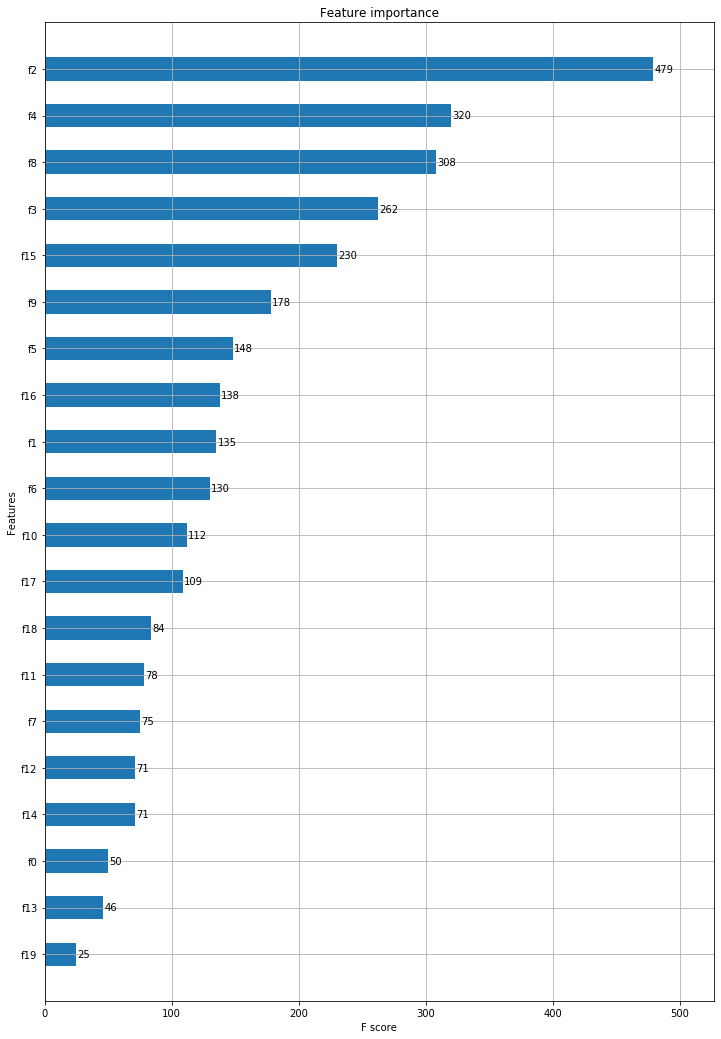

In [20]:
preds = model.predict(testx)
preds = np.clip(preds, 0,20)
df = pd.DataFrame(preds, columns = ['item_cnt_month'])
df['ID'] = df.index
df = df.set_index('ID')
df.to_csv('preds.csv')
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model,max_num_features=80, height=0.5, ax=ax)
plt.show()